In [1]:
# import libraries
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import safe as sf
import datamol as dm

/home/affiah/anaconda3/envs/safe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load pre-trained model
designer = sf.SAFEDesign.load_default(verbose=True)
designer.model

SAFEDoubleHeadsModel(
  (transformer): GPT2Model(
    (wte): Embedding(1880, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=1880, bias=False)
  (multiple_choice_head): PropertyHead(
    (summary): Linear(in_features=768, out_features=64, bias=True)
    

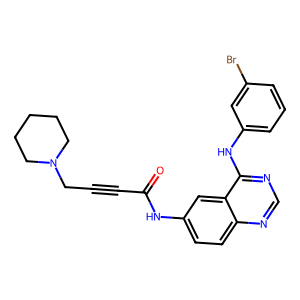

In [3]:
candidate_smiles = "O=C(C#CCN1CCCCC1)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1"
candidate_mol = dm.to_mol(candidate_smiles)

dm.to_image(candidate_mol)

### De Novo Generation

In [4]:
generated_smiles = designer.de_novo_generation(sanitize=True, n_samples_per_trial=12)
generated_smiles[:5]

  0%|          | 0/1 [00:00<?, ?it/s]/home/affiah/anaconda3/envs/safe/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:430: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


2024-01-12 10:51:23.345 | INFO     | safe.sample:de_novo_generation:581 - After sanitization, 8 / 12 (66.67 %) generated molecules are valid !


['COC(=O)C1CC[NH+](CC(=O)NC[C@@H](c2cccc(C)c2)[NH+]2CCOCC2)CC1',
 'C[C@H](OCc1cccc(-c2nn[n-]n2)c1)C(=O)N1CCN(c2cncc(F)c2)CC1',
 'Cc1cc(C(=O)N2CC[C@H](NC(=O)[C@]3(C)CC[C@H](C)C3(C)C)[C@H]2C)no1',
 'C[C@@H](Cc1ccco1)NC(=O)c1cccnc1F',
 'CC(C)Oc1ccccc1[C@H](C)NC(=O)N1CCCN(c2nccs2)CC1']

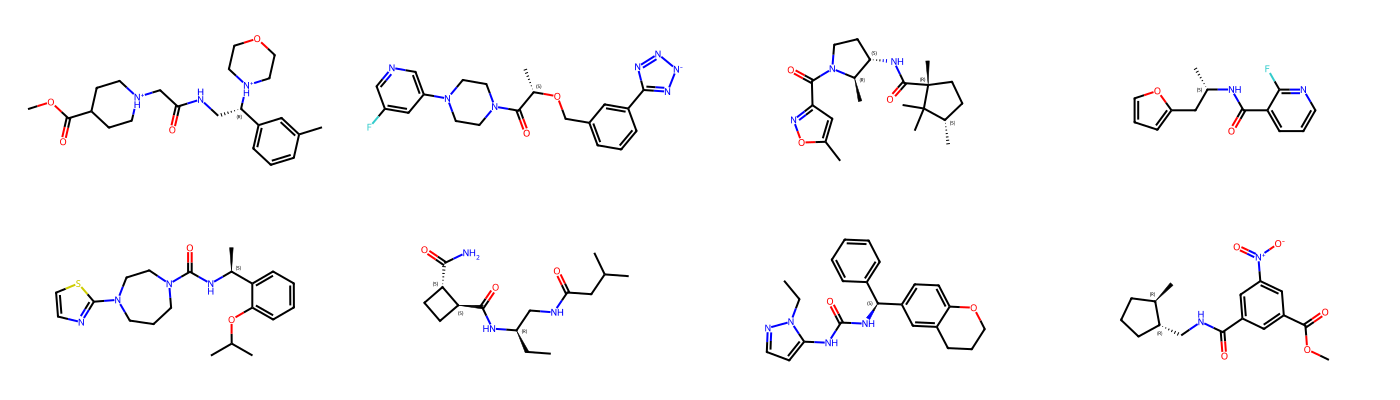

In [5]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))

### Scaffold Generation

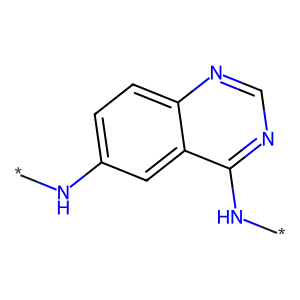

In [6]:
scaffold = "[*]N-c1ccc2ncnc(-N[*])c2c1"

dm.to_image(scaffold)

In [7]:
generated_smiles = designer.scaffold_decoration(
    scaffold=scaffold,
    n_samples_per_trial=12,
    n_trials=2,
    sanitize=True,
    do_not_fragment_further=True,
)

generated_mols = [dm.to_mol(x) for x in generated_smiles]

  0%|          | 0/2 [00:00<?, ?it/s]

2024-01-12 10:54:00.042 | INFO     | safe.sample:scaffold_decoration:542 - After sanitization, 23 / 24 (95.83 %)  generated molecules are valid !


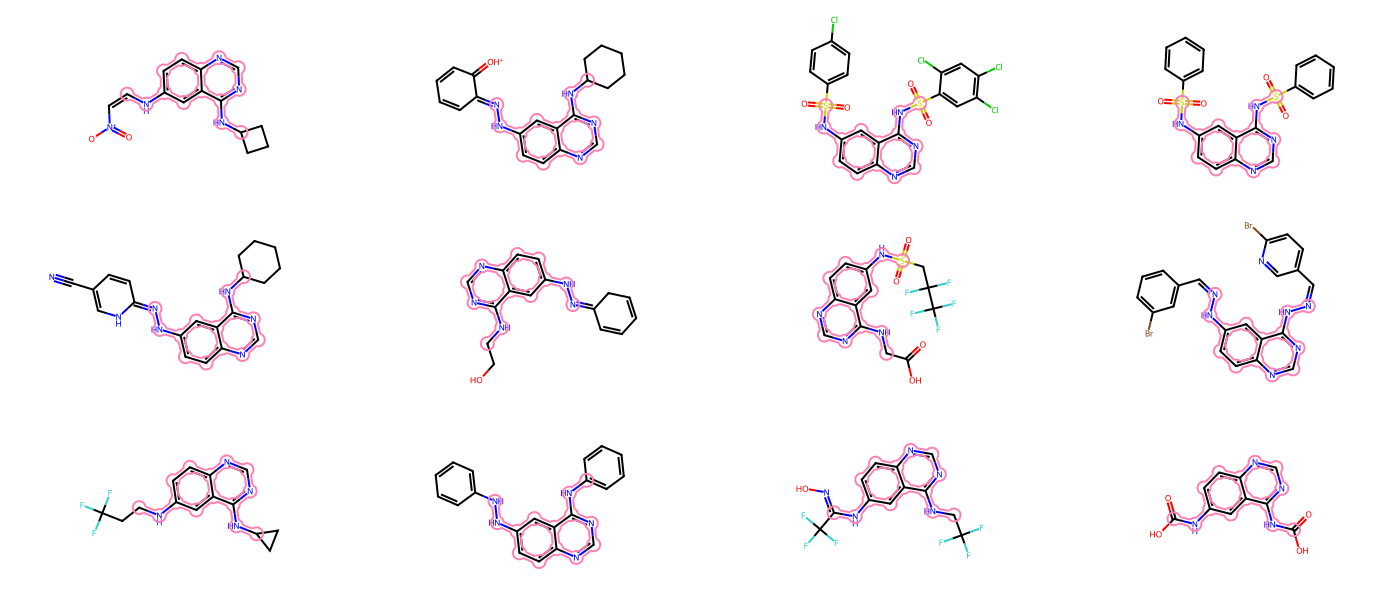

In [8]:
dm.viz.lasso_highlight_image(generated_mols[:12], 
                             dm.from_smarts(scaffold), 
                             mol_size=(350, 200), 
                             color_list=["#ff80b5"], 
                             scale_padding=0.1)

### Scaffold Morphing

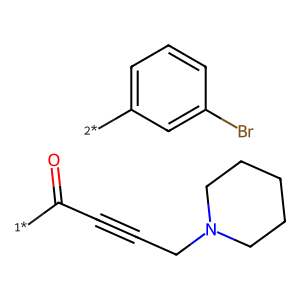

In [9]:
side_chains = "[1*]C(=O)C#CCN1CCCCC1.[2*]c1cccc(Br)c1"
dm.to_image(side_chains)

  0%|          | 0/1 [00:00<?, ?it/s]

2024-01-12 10:54:58.076 | INFO     | safe.sample:_fragment_linking:397 - After sanitization, 12 / 12 (100.00 %)  generated molecules are valid !


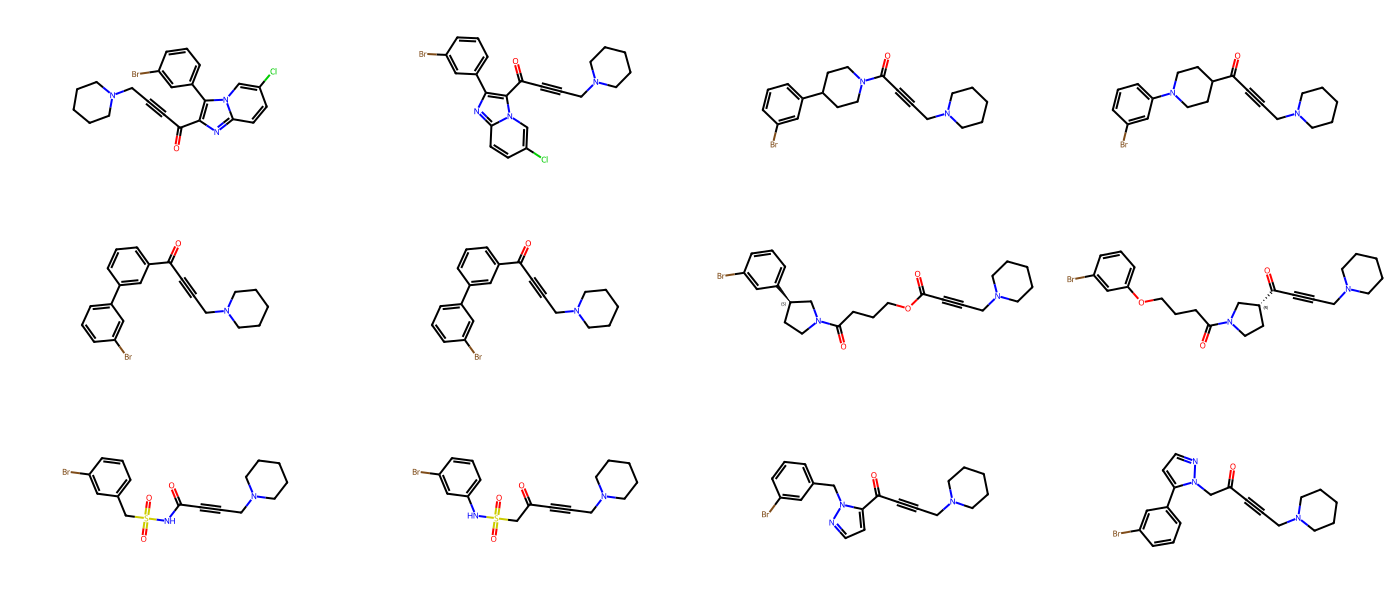

In [10]:
generated_smiles = designer.scaffold_morphing(
    side_chains=side_chains,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    random_seed=100,
)

dm.to_image(generated_smiles[:12], mol_size=(350, 200))

### Super structure generation

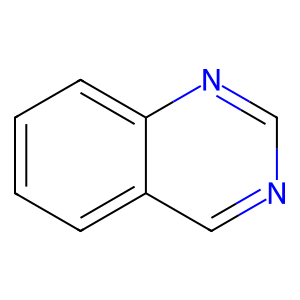

In [11]:
superstructure = "c1ccc2ncncc2c1"
dm.to_image(superstructure)

In [12]:
generated_smiles = designer.super_structure(
    core=superstructure,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    attachment_point_depth=3,
)

generated_smiles

  0%|          | 0/1 [00:00<?, ?it/s]

2024-01-12 10:55:31.601 | INFO     | safe.sample:super_structure:496 - After sanitization, 12 / 12 (100.00 %)  generated molecules are valid !


['BrCCCCCCCCCCCCCCc1cc(CCCCCCCCCCCCBr)cc2ncnc(CCCCCCCCCCCCCBr)c12',
 'FC(F)(F)c1cc(C(F)(F)F)c2c(SCCCCCCCCCCCCBr)ncnc2c1',
 'FC(F)(F)c1cc(C(F)(F)F)c2c(C(F)(F)F)ncnc2c1',
 'FC(F)c1ncnc2cc(C(F)(F)F)cc(C(F)(F)F)c12',
 'O=[N+]([O-])c1cc([N+](=O)[O-])c2c([N+](=O)[O-])ncnc2c1',
 'FC(F)(F)c1cc(C(F)(F)F)c2c(C(F)(F)F)ncnc2c1',
 'FC(F)(F)c1cc(C(F)(F)F)c2c(CBr)ncnc2c1',
 'OCc1cc(C(F)(F)F)c2c(C(F)(F)F)ncnc2c1',
 'OCc1ncnc2cc(C(F)(F)F)cc(C(F)(F)F)c12',
 'FC(F)(F)c1ncnc2cc(CCl)cc(CCl)c12',
 'FC(F)(F)c1cc(C(F)(F)F)c2c(C(F)(F)F)ncnc2c1',
 'O=[N+]([O-])c1cc([N+](=O)[O-])c2c([N+](=O)[O-])ncnc2c1']

### Motif Extension

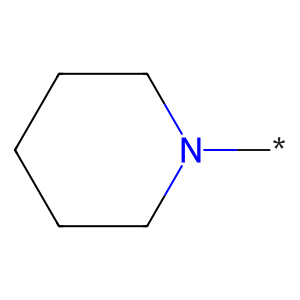

In [13]:
motif = "[*]-N1CCCCC1"
dm.to_image(motif)

In [14]:
# let's make some long sequence
generated_smiles = designer.motif_extension(
    motif=motif,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    min_length=25,
    max_length=80,
)

generated_smiles

  0%|          | 0/1 [00:00<?, ?it/s]

2024-01-12 10:55:57.491 | INFO     | safe.sample:scaffold_decoration:542 - After sanitization, 12 / 12 (100.00 %)  generated molecules are valid !


['O=C(NCC(F)(F)CN1CCCCC1)OCC(F)(F)F',
 'NS(=O)(=O)CCCCCNC(=O)CCCCS(=O)(=O)N1CCCCC1',
 'O=C([O-])CCCCNC(=O)NCC(=O)N1CCCCC1',
 'CC[Si](Cl)(Cl)N(Cl)Cl.ClN(Cl)[Si](Cl)(Cl)N1CCCCC1',
 'O=C([O-])CSCC(=O)NCC(=O)N1CCCCC1',
 'NC(NCCCCCC(=O)[O-])=[NH+]CCN1CCCCC1',
 'O=C(CC(F)(F)F)N1CCCCC1',
 'O=C(CCS(=O)(=O)[O-])N1CCCCC1',
 'N[C@@H](C[S+]([O-])CC(=O)N1CCCCC1)CC(F)(F)F',
 'O[C@H](CNC(=S)NCC(F)(F)C(F)(F)F)CN1CCCCC1',
 'O=C([O-])C[C@@H](O)CNC(=O)CCC(=O)N1CCCCC1',
 'O=C([O-])CCCS(=O)(=O)CC(=O)N1CCCCC1']

### Linker generation

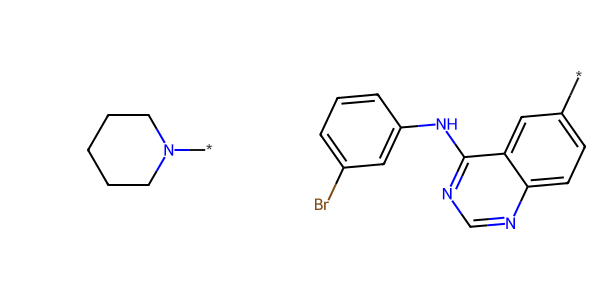

In [15]:
linker_generation = ["[*]-N1CCCCC1", "Brc1cccc(Nc2ncnc3ccc(-[*])cc23)c1"]
dm.to_image(linker_generation)

In [16]:
generated_smiles = designer.linker_generation(
    *linker_generation,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    random_seed=100,
)

generated_smiles

  0%|          | 0/1 [00:00<?, ?it/s]

2024-01-12 10:57:17.662 | INFO     | safe.sample:_fragment_linking:397 - After sanitization, 12 / 12 (100.00 %)  generated molecules are valid !


['Brc1cccc(Nc2ncnc3ccc(-c4ccc(N5CC(N6CCCCC6)N(c6ccccc6)C5)cc4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(C4CN(c5ccc(N6CCCCC6)cc5)CN4c4ccccc4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(CCOCN4CCCCC4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(COCCN4CCCCC4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(-c4nccn4-c4cc(N5CCCCC5)cc(-n5ccnc5)n4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(-c4cc(-n5ccnc5)nc(-n5ccnc5N5CCCCC5)c4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(C45CC6CC7CC(N8CCCCC8)CC7CC47C(C6)C57)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(C4CC5CC6CC7C8C7(CC5C4)C8(N4CCCCC4)C6)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(-c4nc5sc6c(N7CCCCC7)nc(N7CCCCC7)nc6c5c5c4CCCC5)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(-c4nc(N5CCCCC5)c5sc6nc(N7CCCCC7)c7c(c6c5n4)CCCC7)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(-c4ncnc(Nc5ccc(Oc6ccc7c(c6)c(-c6ccccc6)c(-c6ccccc6)n7-c6ncnc(N7CCCCC7)n6)cc5)n4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(-c4ncnc(-n5c(-c6ccccc6)c(-c6ccccc6)c6cc(Oc7ccc(Nc8ncnc(N9CCCCC9)n8)cc7)ccc65)n4)cc23)c1']